In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
import cv2

In [5]:
pd.set_option("display.precision", 8)

In [6]:
os.getcwd()

'F:\\Raspberry Pi\\Meetup TensorflowUserGroup Bangalore'

In [7]:
root = 'Data/train'

In [8]:
img = cv2.imread(root+'/1/frame100.jpg')

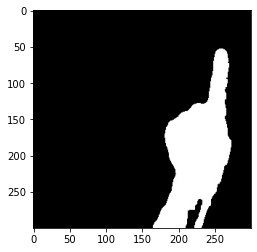

In [9]:
plt.imshow(img)

In [10]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(root)
print(TRAINING_DATA_DIR)

Data/train


In [11]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)

Found 907 images belonging to 5 classes.


In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

Found 3644 images belonging to 5 classes.


In [13]:
image_batch_train, label_batch_train = next(iter(train_generator))

print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
['1' '2' '3' '4' '5']


In [14]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [15]:
FV_SIZE

1280

In [17]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                  output_shape=[FV_SIZE],
                                  trainable=False)

In [18]:
# Build a sequential model with feature_extractor. Sequential, groups a linear stack of layers into a tf.keras.Model
model = tf.keras.Sequential([
feature_extractor,
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.3), 
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

In [19]:
# Build the model manually 
model.build([None, 224, 224, 3])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 2,602,693
Trainable params: 344,709
Non-trainable params: 2,257,984
________________________________________

In [21]:
# Configure the model for training.
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
loss='categorical_crossentropy',
metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

filepath = 'checkpoints/'
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min'),
                tf.keras.callbacks.ModelCheckpoint (filepath+'model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=False, monitor='val_loss', mode='min')]

#Trains the model for a fixed number of epochs (iterations on a dataset).
hist = model.fit(
train_generator,
epochs=30,
verbose=1,
callbacks=my_callbacks,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

In [ ]:
#'checkpoints/model.08-0.33.hdf5'

In [119]:
model = tf.keras.models.load_model('checkpoints/model.08-0.33.hdf5',custom_objects={'KerasLayer':hub.KerasLayer})

In [108]:
#loaded = tf.keras.models.load_model('checkpoints/model.08-0.33.hdf5')

In [105]:
# export the model
SAVED_MODEL = 'gestures_saved_model'

In [106]:
tf.saved_model.save(model, SAVED_MODEL)

INFO:tensorflow:Assets written to: gestures_saved_model\assets


INFO:tensorflow:Assets written to: gestures_saved_model\assets


In [120]:
loaded_model = tf.saved_model.load(SAVED_MODEL)

In [32]:
print(list(loaded_model.signatures.keys()))
infer = loaded_model.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name='keras_layer_input')})
{'dense_5': TensorSpec(shape=(None, 5), dtype=tf.float32, name='dense_5')}


In [27]:
test_root = 'Data/test'

In [28]:
TEST_DIR = str(test_root)

In [37]:
datagen_kwargs = dict(rescale=1./255)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

test_generator = test_datagen.flow_from_directory(
TEST_DIR,
shuffle=False,
target_size=IMAGE_SHAPE
)

Found 384 images belonging to 5 classes.


In [38]:
image_batch_test, label_batch_test = next(iter(test_generator))

print("Image batch shape: ", image_batch_test.shape)
print("Label batch shape: ", label_batch_test.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [39]:
test_image_batch, test_label_batch = next(iter(test_generator))
true_label_ids = np.argmax(test_label_batch, axis=-1)
print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


### TFLite converter

In [121]:
# Convert the model to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)

In [122]:
# specify the optimizations 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

In [123]:
tflite_model_file = 'converted_optimised_model.tflite'

In [124]:
tflite_model = converter.convert()
#tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

### Test the model using TFLite Interpreter

In [125]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.resize_tensor_input(0, [1, 224, 224, 3], strict=True)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [126]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
true_labels = []
for i in range(12):
    a,b = test_generator[i]
    for j in range(32):
        img, label = tf.expand_dims(a[j], axis=0), b[j]
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        #print(np.argmax(interpreter.get_tensor(output_index)))
        predictions.append(np.argmax(interpreter.get_tensor(output_index)))
        #print(label)
        true_labels.append(np.argmax(label))
        test_imgs.append(img)

In [127]:
len(predictions)

384

Label: 1


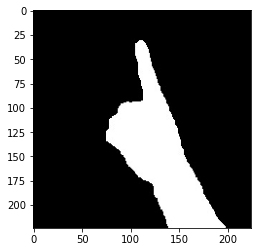

Label: 1


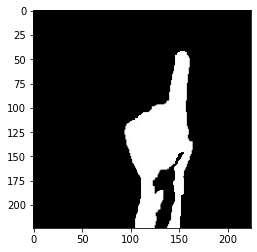

Label: 1


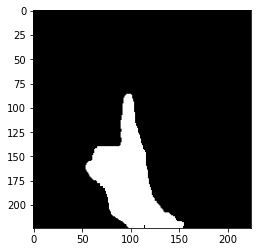

Label: 1


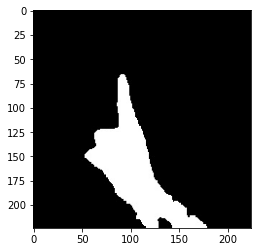

Label: 1


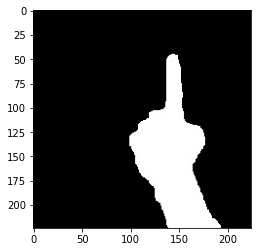

Label: 1


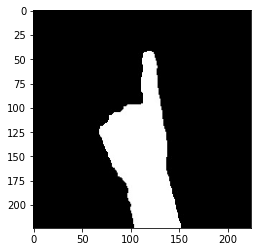

Label: 1


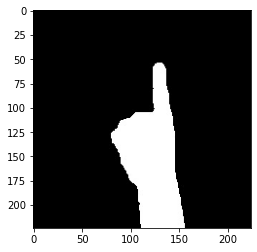

Label: 1


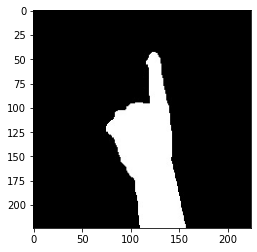

Label: 1


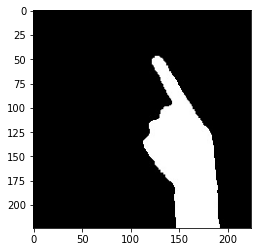

Label: 1


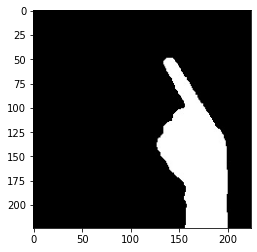

Label: 1


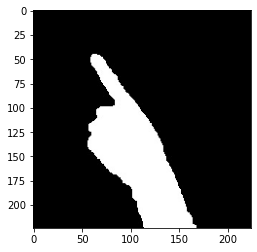

Label: 1


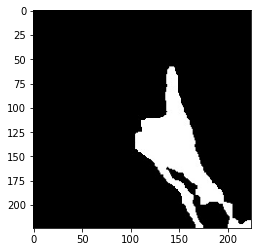

Label: 1


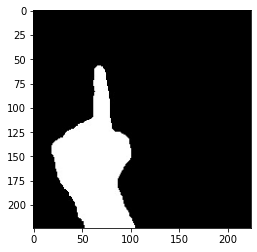

Label: 1


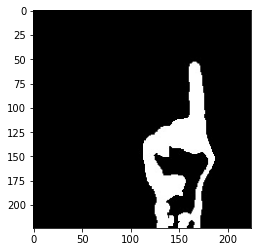

Label: 1


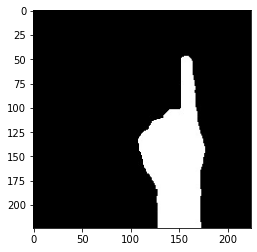

Label: 1


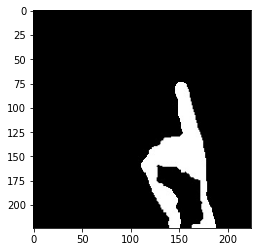

Label: 1


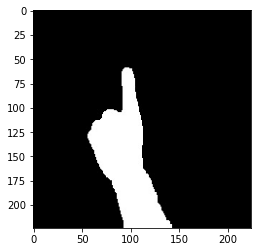

Label: 1


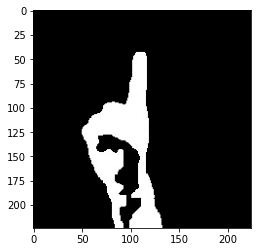

Label: 1


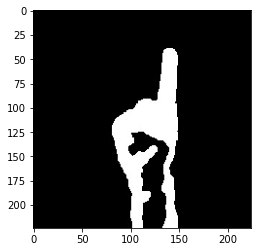

Label: 1


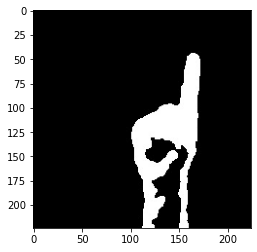

Label: 1


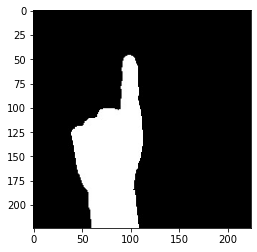

Label: 1


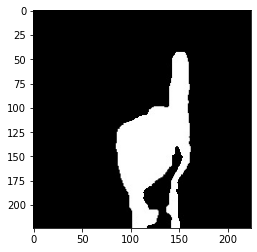

Label: 1


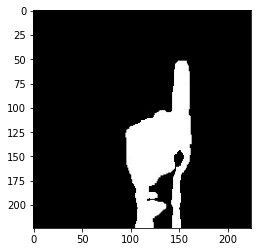

Label: 1


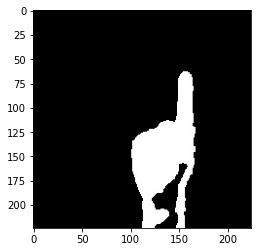

Label: 1


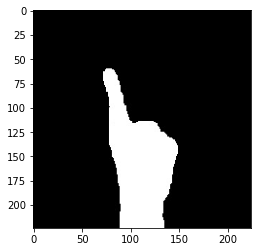

Label: 1


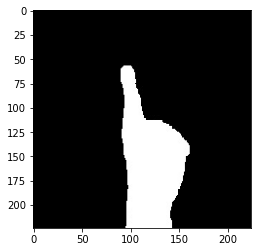

Label: 1


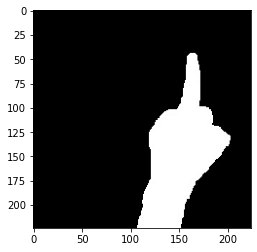

Label: 1


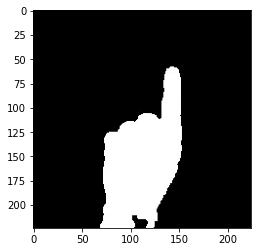

Label: 1


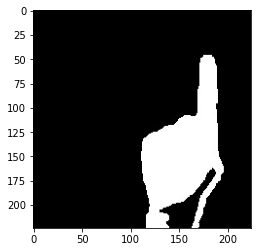

Label: 1


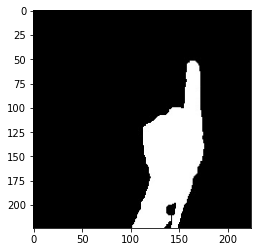

Label: 1


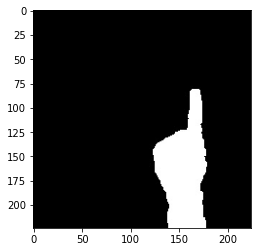

Label: 1


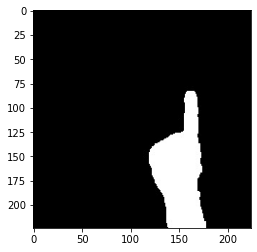

Label: 1


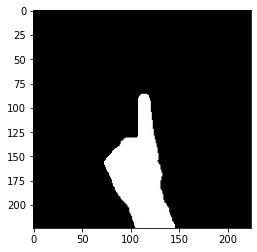

Label: 1


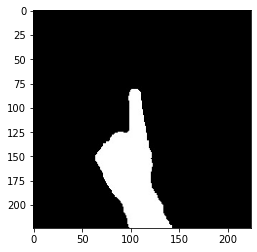

Label: 1


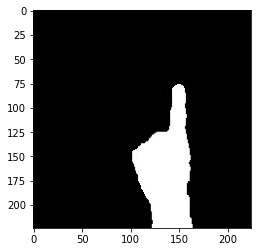

Label: 1


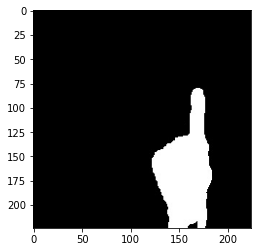

Label: 1


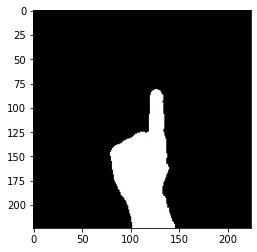

Label: 1


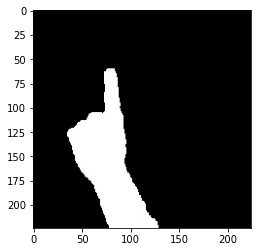

Label: 1


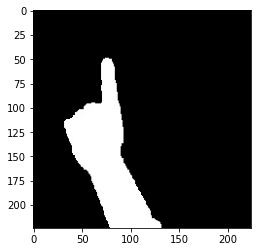

Label: 1


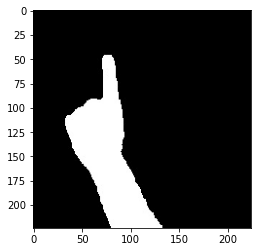

Label: 1


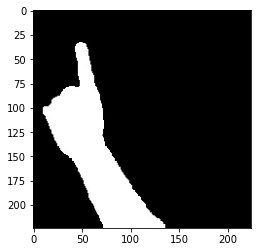

Label: 1


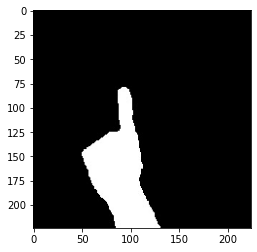

Label: 1


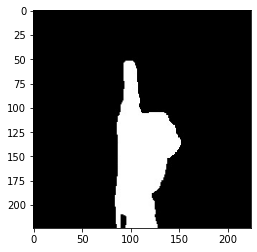

Label: 1


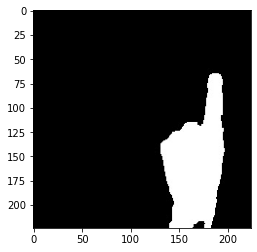

Label: 1


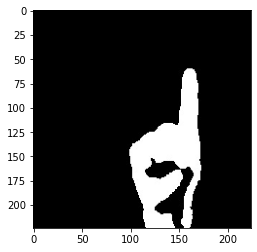

Label: 1


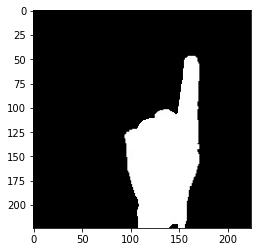

Label: 1


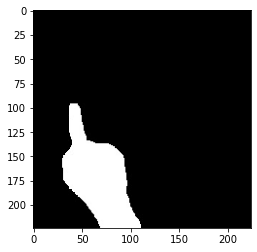

Label: 1


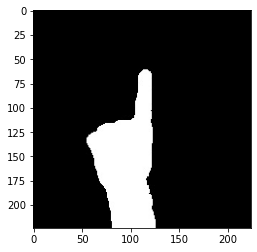

Label: 1


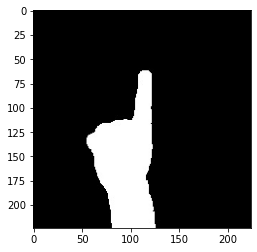

Label: 1


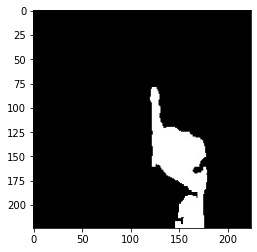

Label: 1


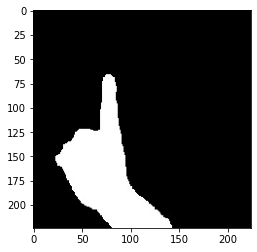

Label: 1


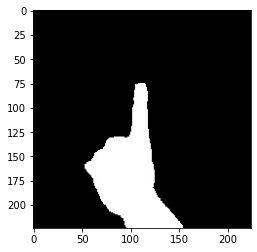

Label: 1


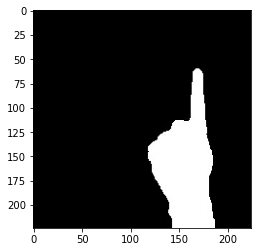

Label: 1


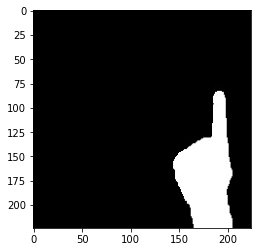

Label: 1


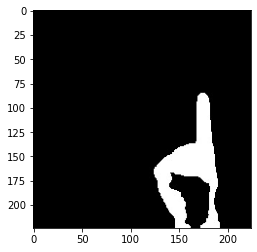

Label: 1


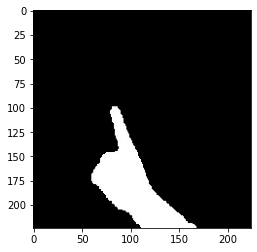

Label: 1


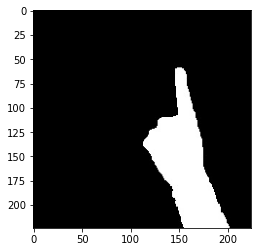

Label: 1


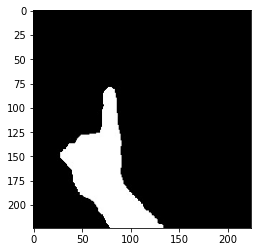

Label: 1


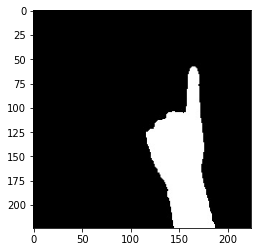

Label: 1


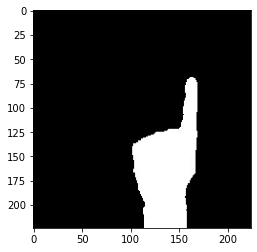

Label: 1


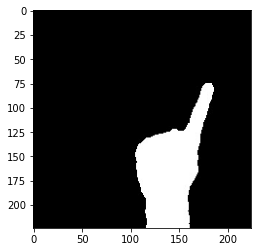

Label: 1


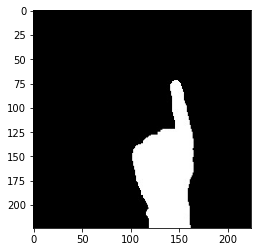

Label: 1


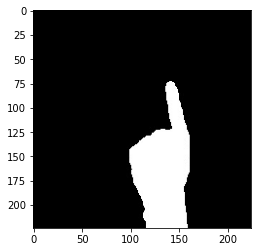

Label: 1


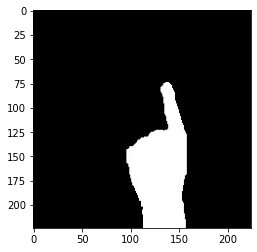

Label: 1


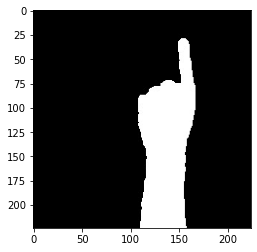

Label: 1


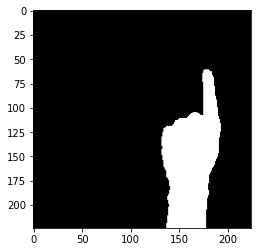

Label: 1


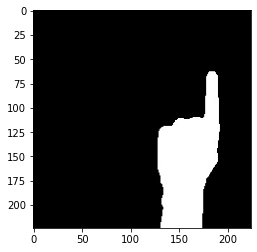

Label: 1


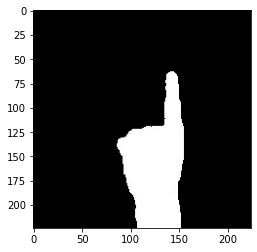

Label: 1


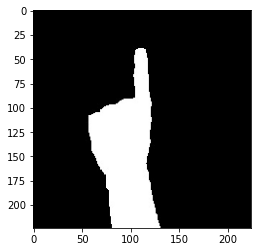

Label: 1


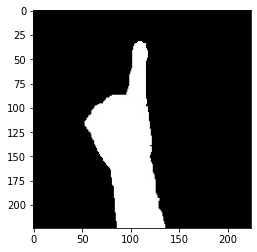

Label: 1


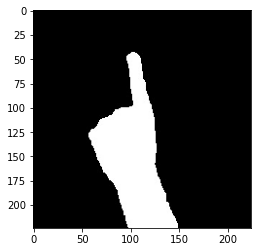

Label: 1


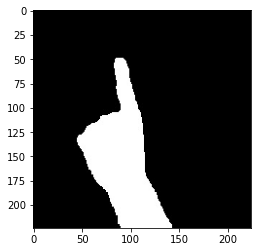

Label: 1


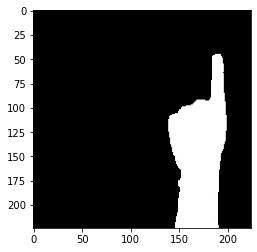

Label: 1


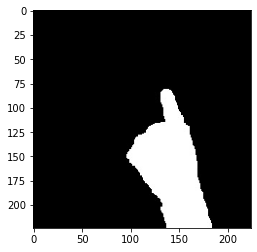

Label: 1


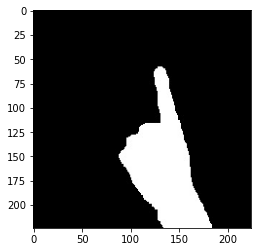

Label: 1


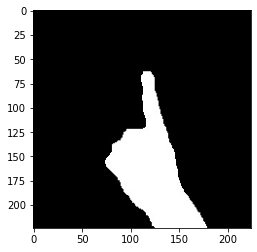

Label: 1


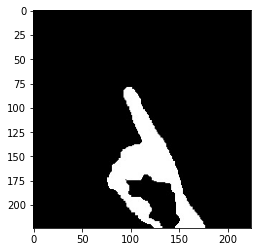

Label: 1


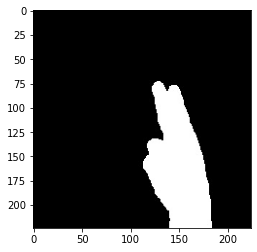

Label: 1


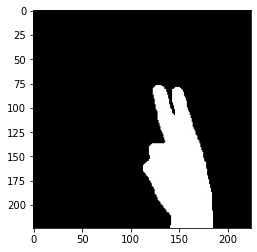

Label: 3


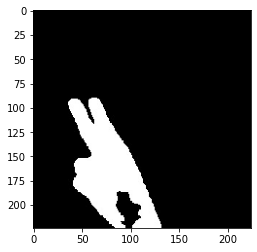

Label: 3


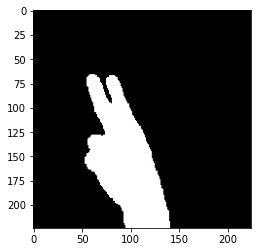

Label: 3


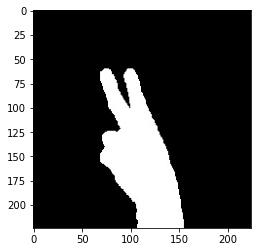

Label: 1


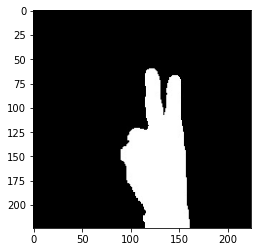

Label: 3


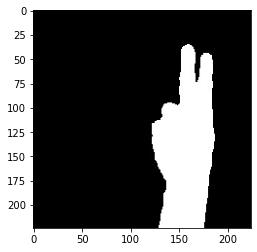

Label: 1


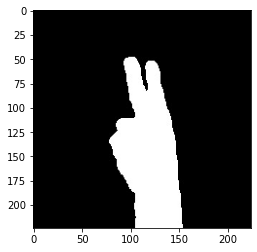

Label: 3


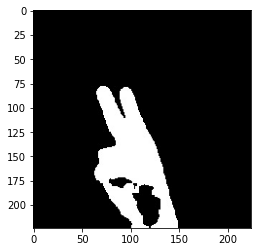

Label: 3


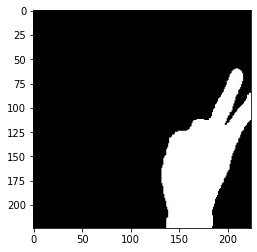

Label: 1


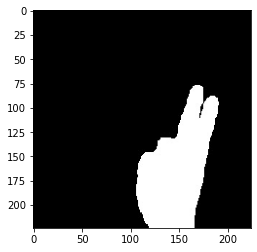

Label: 1


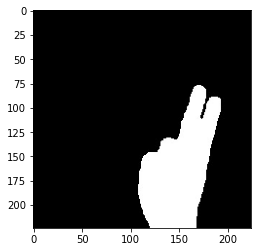

Label: 3


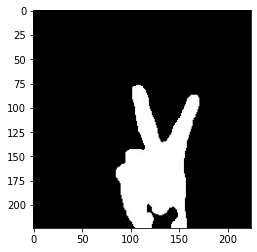

Label: 1


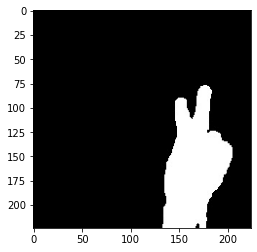

Label: 1


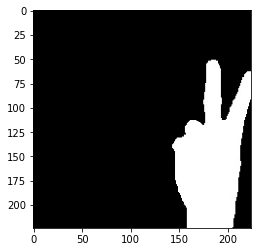

Label: 1


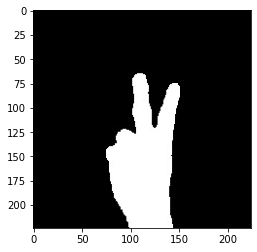

Label: 3


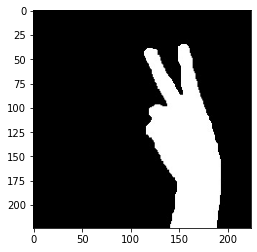

Label: 3


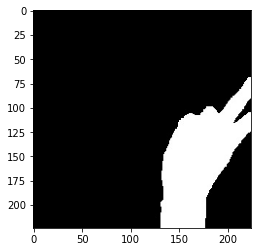

Label: 2


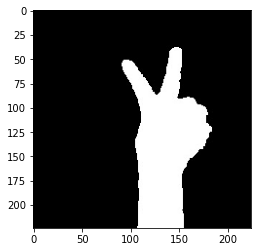

Label: 1


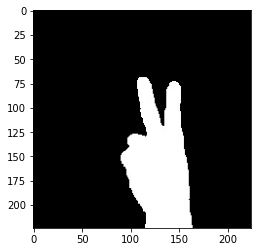

Label: 1


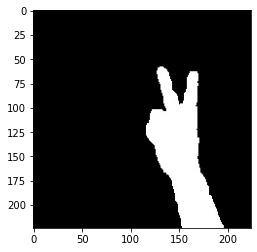

Label: 3


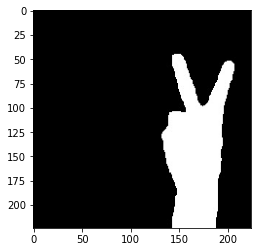

Label: 3


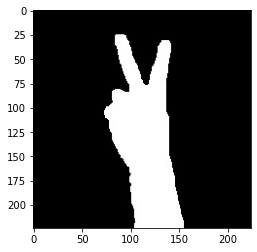

Label: 3


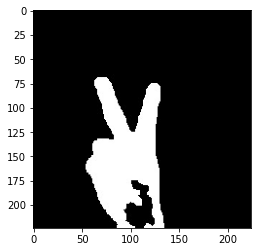

Label: 1


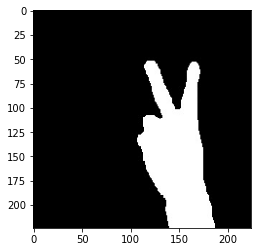

Label: 1


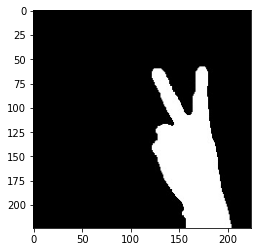

Label: 3


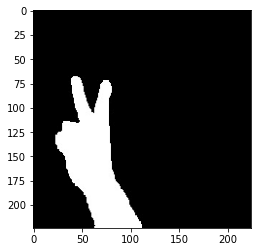

Label: 3


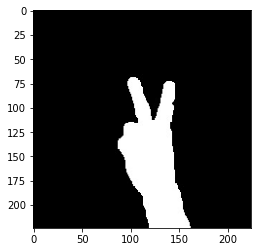

Label: 2


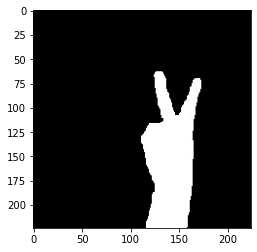

Label: 1


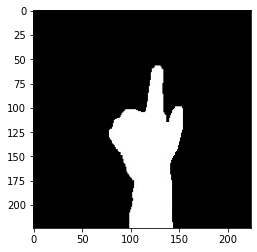

Label: 1


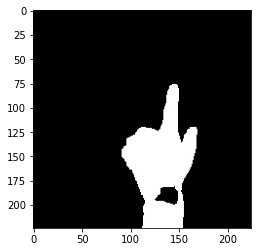

Label: 1


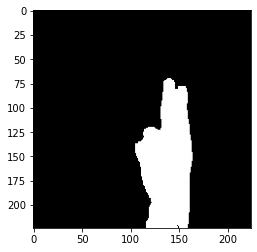

Label: 1


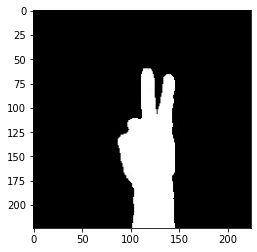

Label: 1


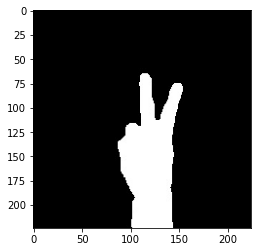

Label: 2


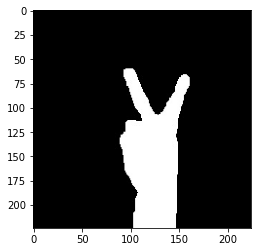

Label: 3


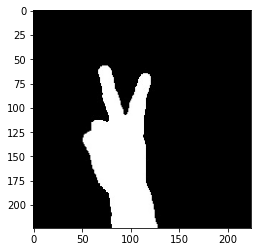

Label: 3


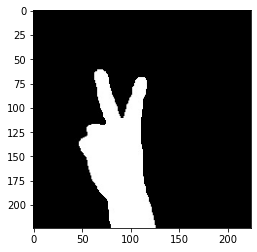

Label: 3


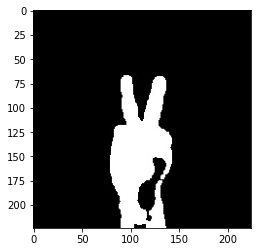

Label: 1


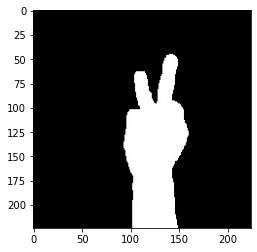

Label: 3


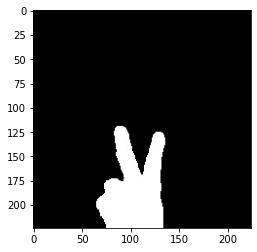

Label: 1


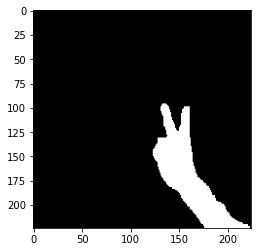

Label: 1


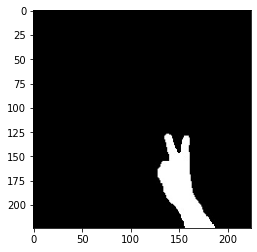

Label: 1


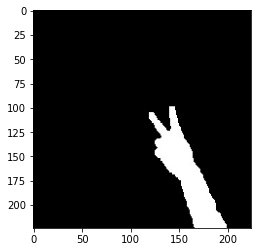

Label: 3


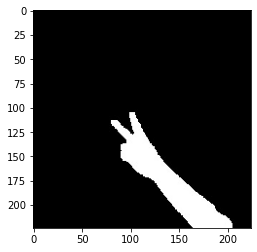

Label: 1


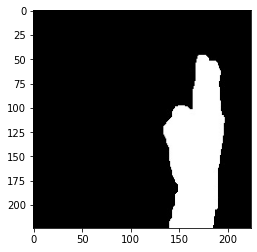

Label: 1


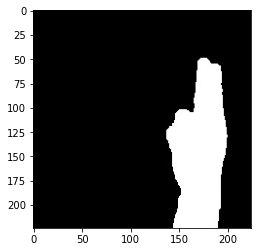

Label: 1


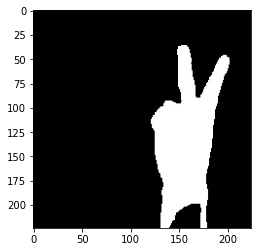

Label: 1


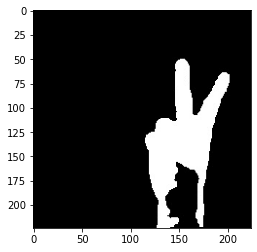

Label: 1


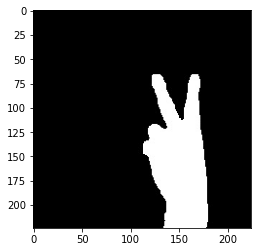

Label: 3


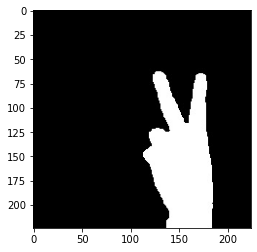

Label: 1


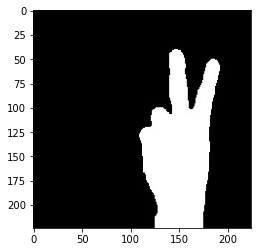

Label: 3


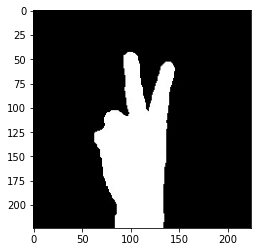

Label: 2


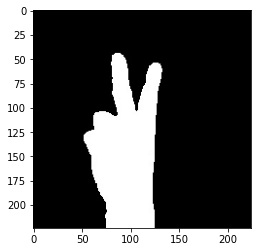

Label: 3


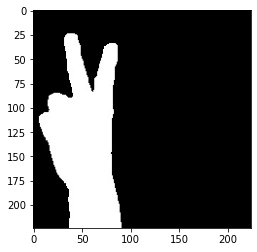

Label: 1


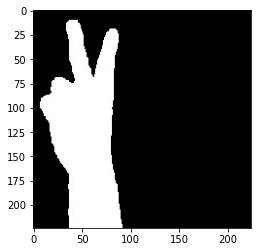

Label: 1


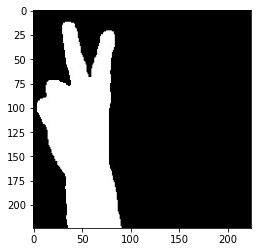

Label: 3


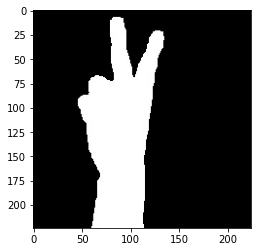

Label: 1


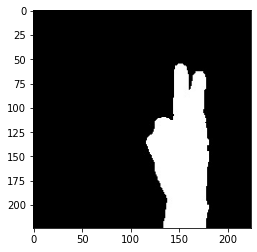

Label: 1


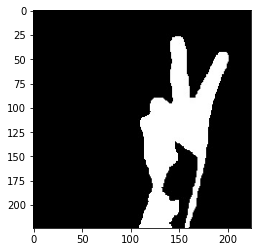

Label: 1


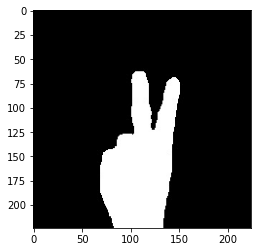

Label: 3


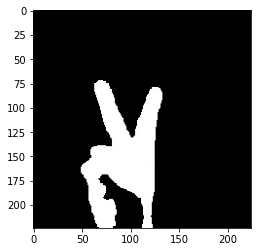

Label: 3


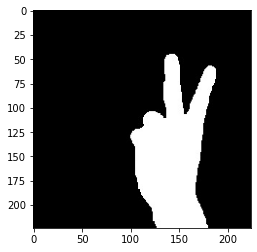

Label: 3


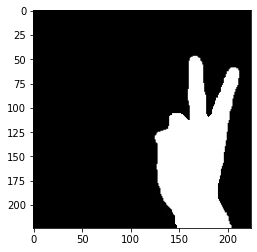

Label: 3


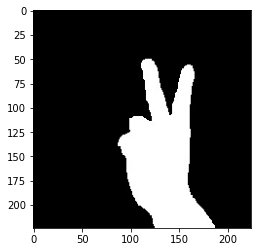

Label: 3


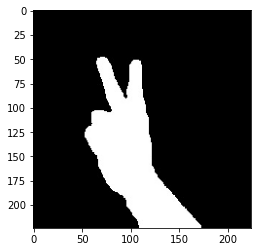

Label: 3


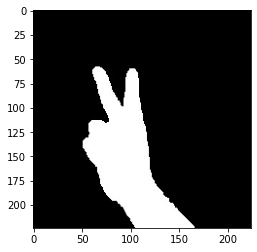

Label: 3


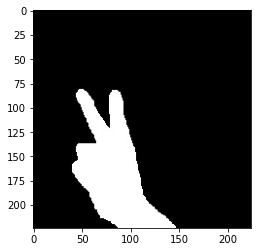

Label: 3


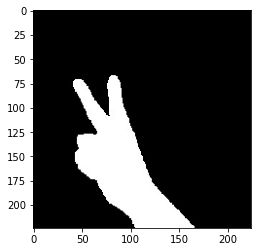

Label: 3


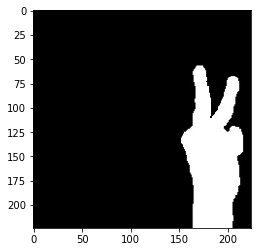

Label: 1


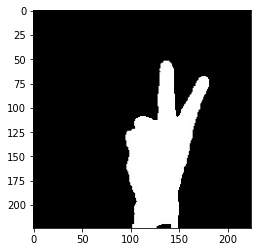

Label: 1


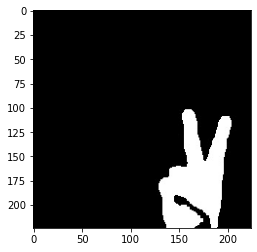

Label: 3


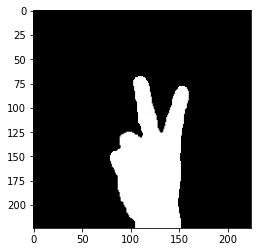

Label: 3


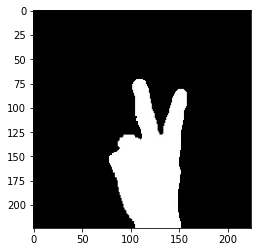

Label: 3


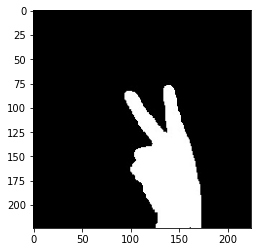

Label: 1


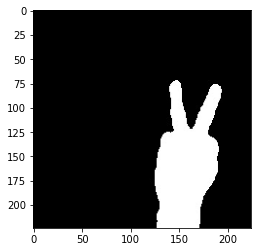

Label: 1


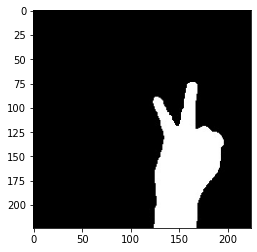

Label: 3


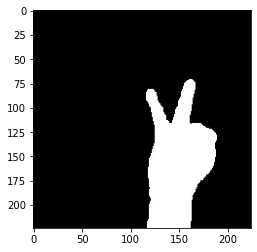

Label: 2


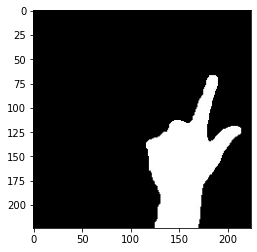

Label: 1


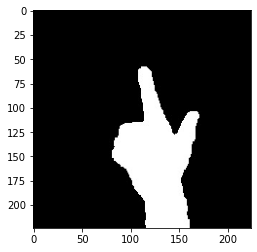

Label: 1


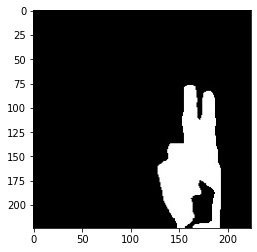

Label: 1


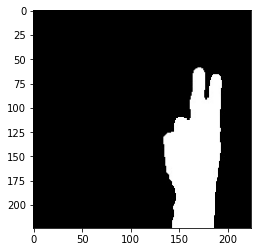

Label: 3


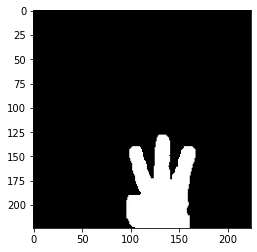

Label: 3


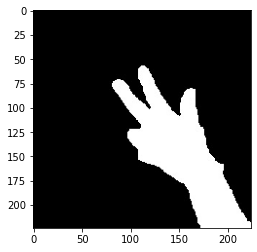

Label: 4


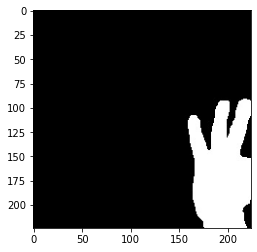

Label: 3


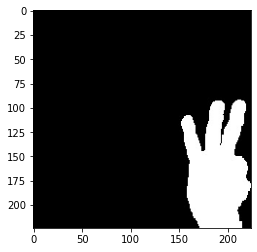

Label: 1


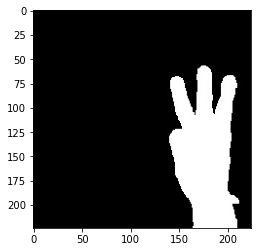

Label: 3


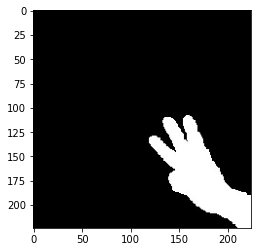

Label: 3


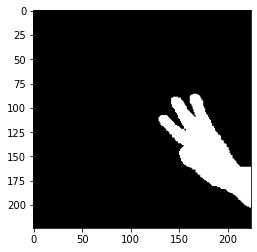

Label: 3


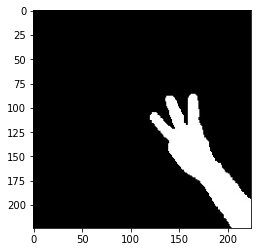

Label: 3


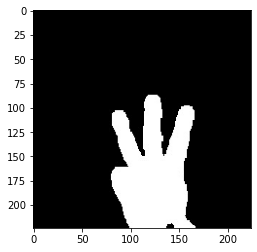

Label: 3


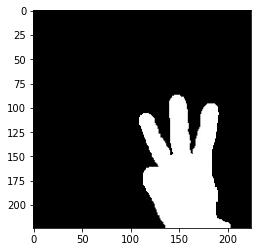

Label: 3


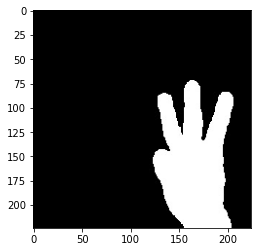

Label: 4


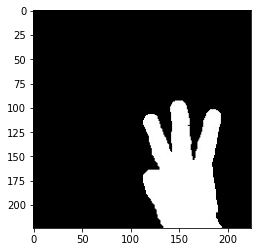

Label: 3


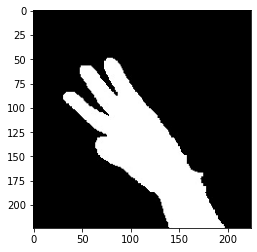

Label: 3


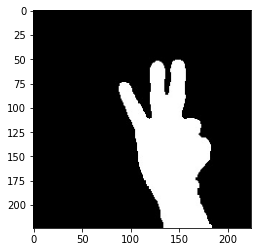

Label: 3


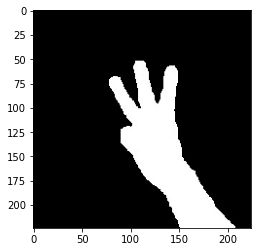

Label: 3


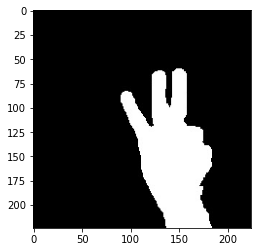

Label: 3


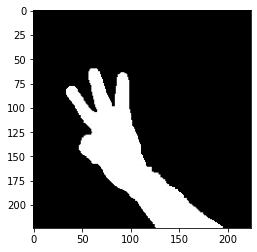

Label: 3


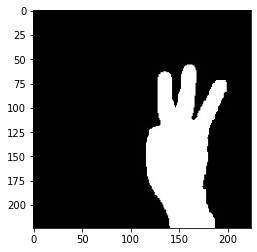

Label: 3


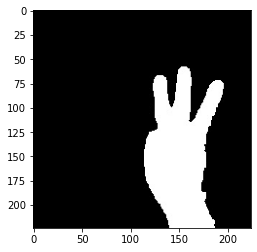

Label: 3


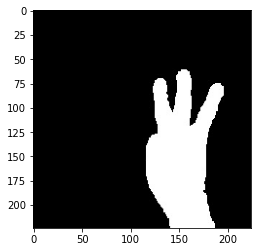

Label: 3


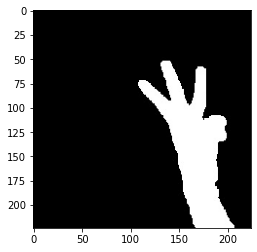

Label: 3


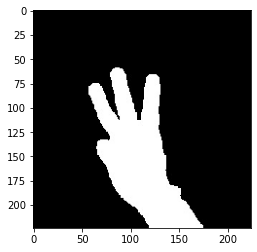

Label: 3


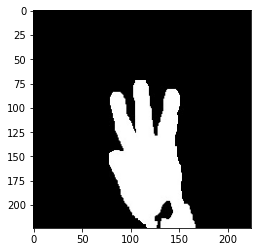

Label: 1


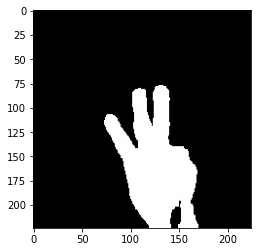

Label: 3


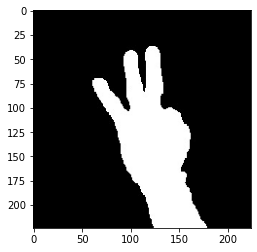

Label: 3


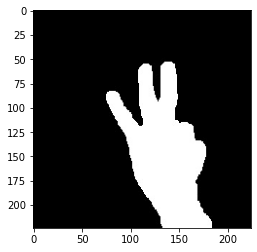

Label: 3


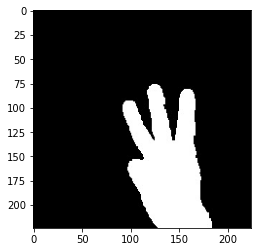

Label: 3


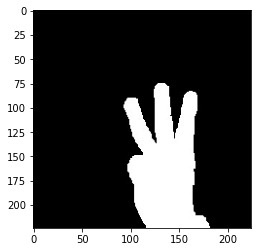

Label: 3


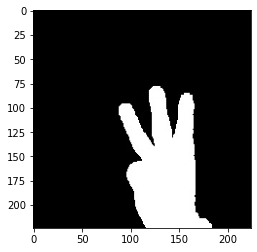

Label: 3


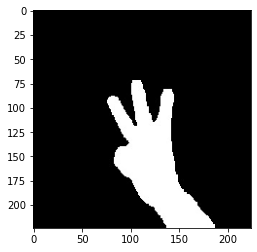

Label: 3


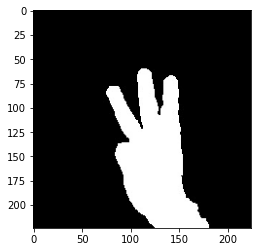

Label: 3


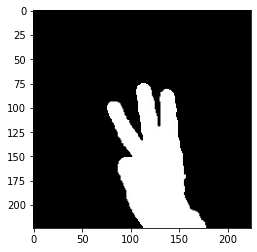

Label: 3


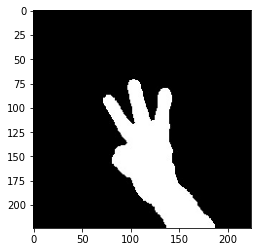

Label: 3


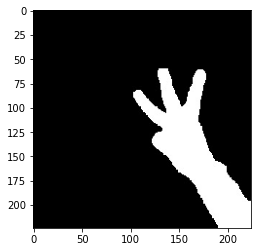

Label: 3


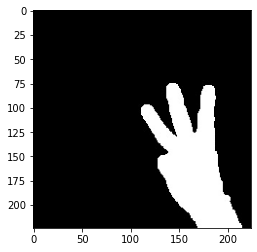

Label: 3


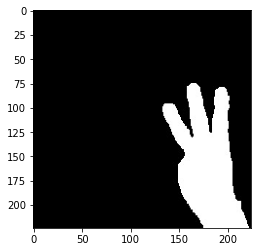

Label: 3


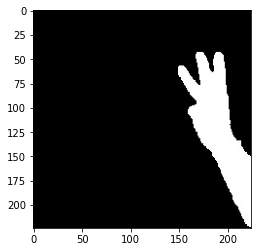

Label: 3


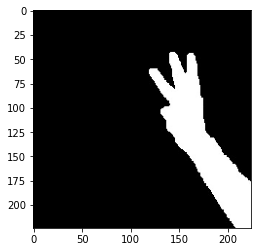

Label: 3


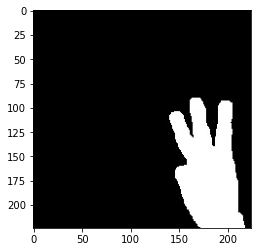

Label: 3


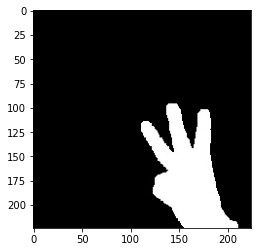

Label: 3


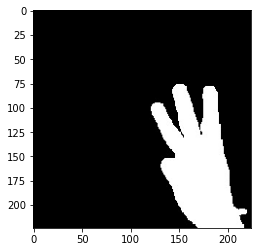

Label: 3


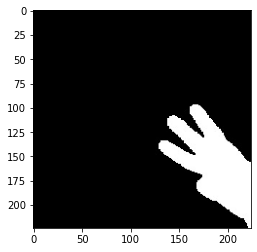

Label: 3


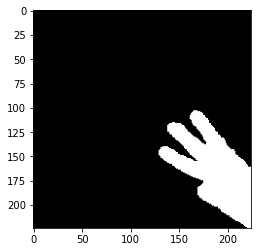

Label: 5


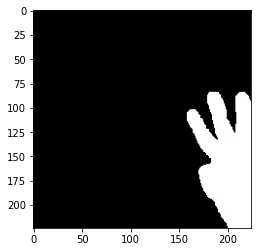

Label: 3


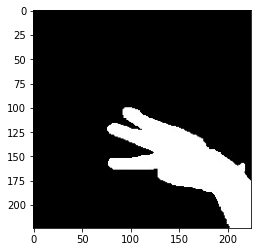

Label: 5


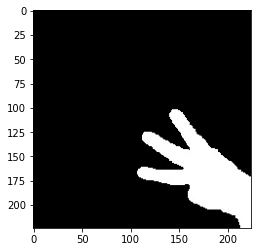

Label: 3


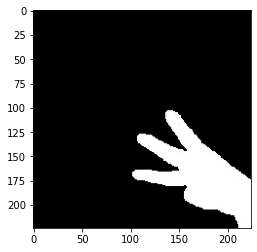

Label: 3


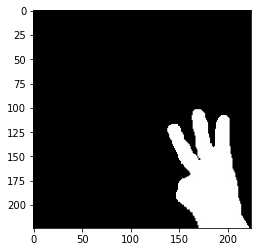

Label: 3


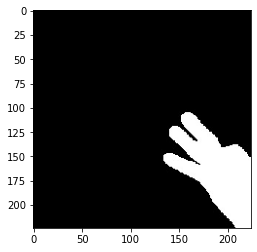

Label: 1


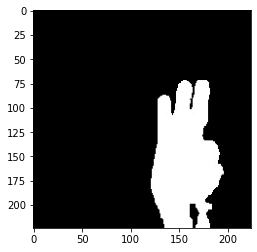

Label: 3


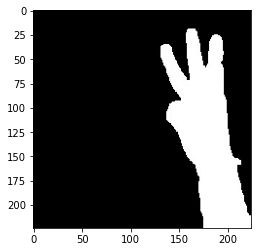

Label: 3


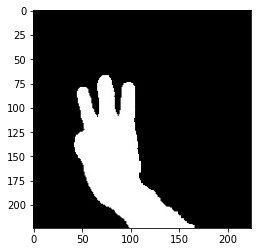

Label: 3


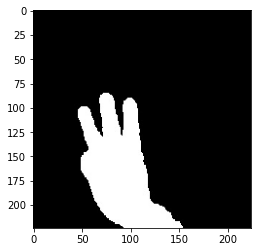

Label: 3


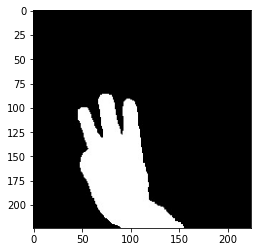

Label: 3


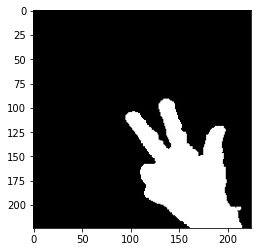

Label: 3


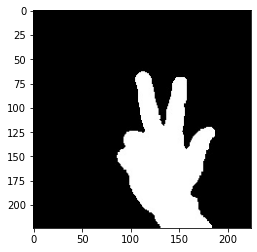

Label: 3


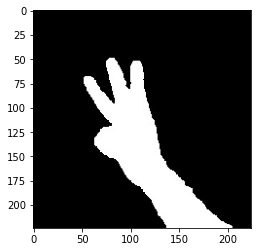

Label: 3


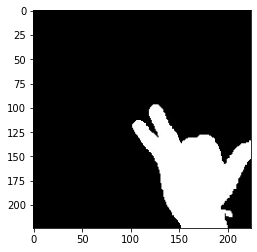

Label: 5


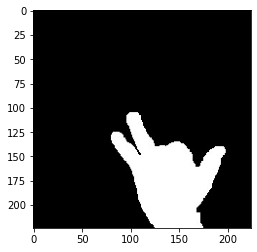

Label: 3


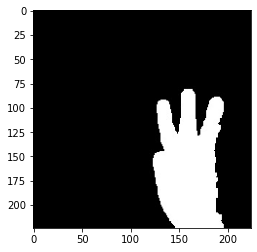

Label: 3


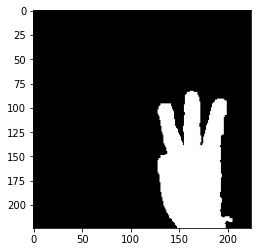

Label: 3


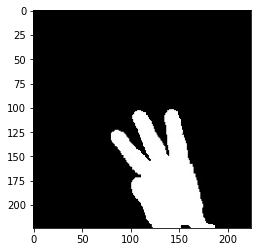

Label: 3


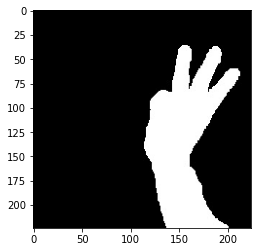

Label: 3


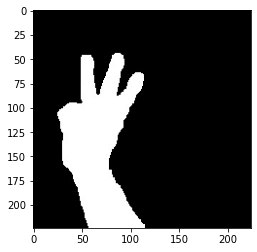

Label: 4


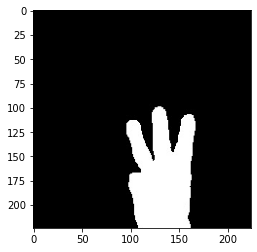

Label: 4


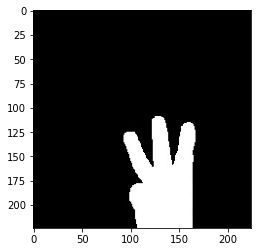

Label: 3


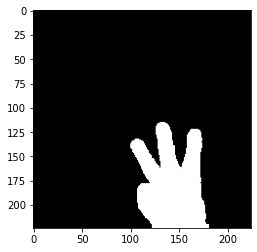

Label: 3


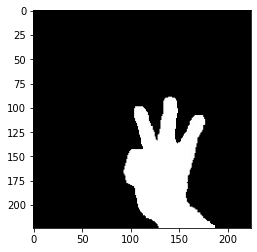

Label: 3


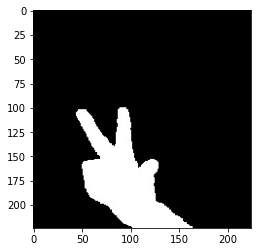

Label: 3


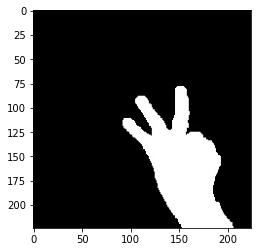

Label: 3


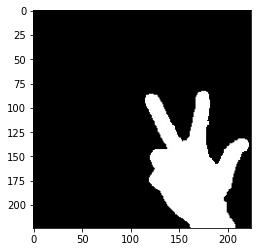

Label: 3


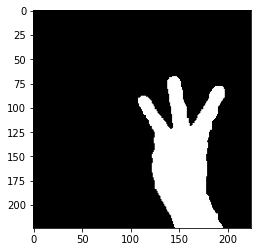

Label: 3


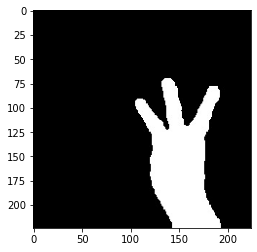

Label: 3


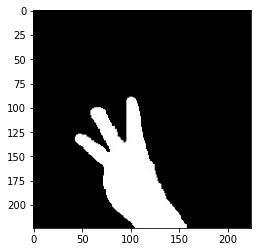

Label: 3


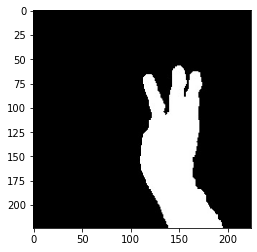

Label: 3


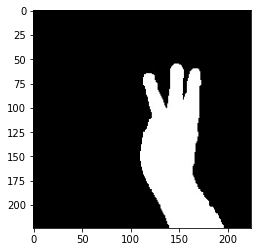

Label: 3


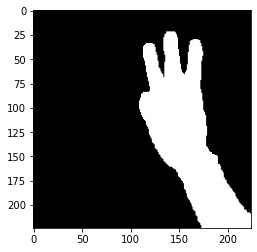

Label: 3


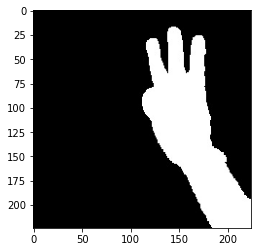

Label: 3


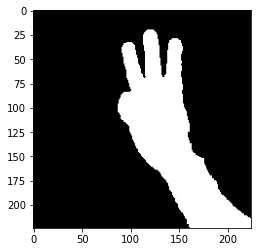

Label: 3


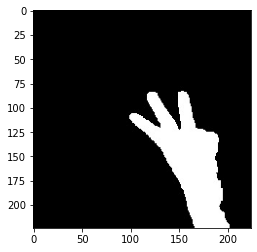

Label: 4


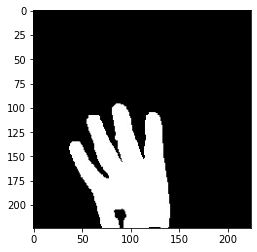

Label: 4


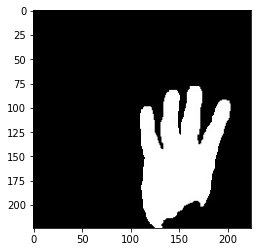

Label: 4


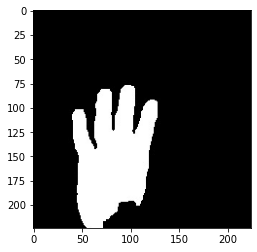

Label: 4


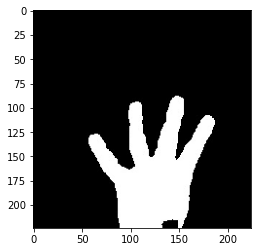

Label: 4


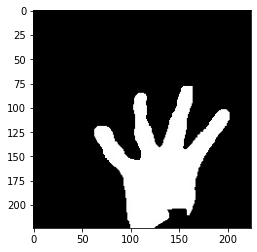

Label: 4


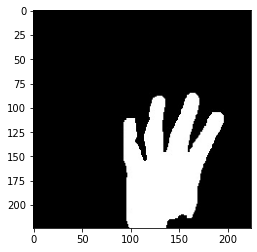

Label: 4


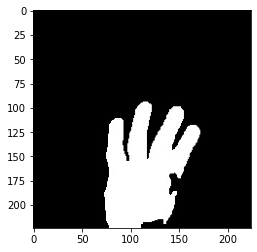

Label: 4


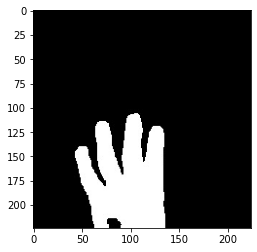

Label: 4


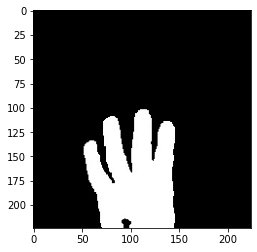

Label: 4


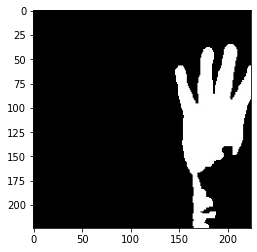

Label: 4


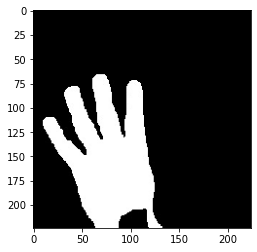

Label: 4


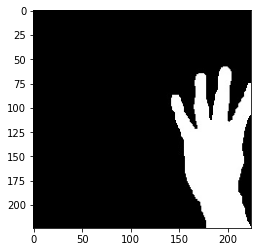

Label: 5


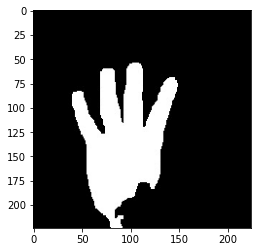

Label: 5


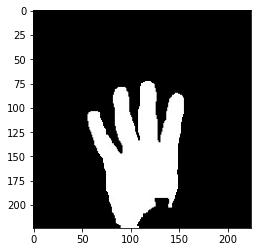

Label: 4


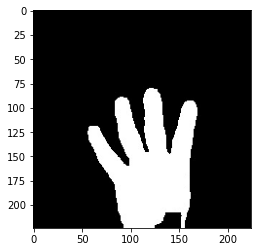

Label: 4


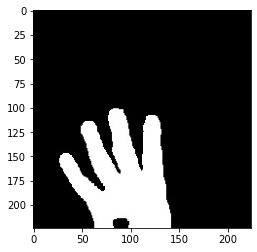

Label: 3


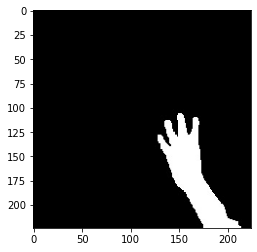

Label: 5


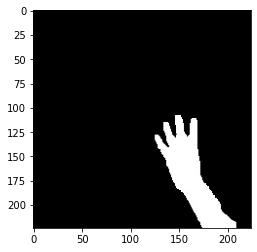

Label: 3


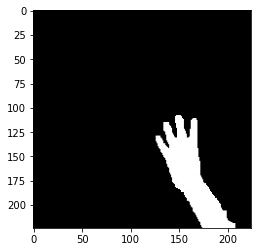

Label: 4


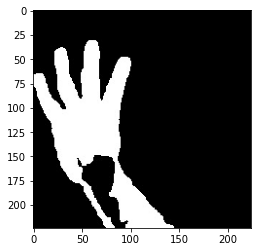

Label: 4


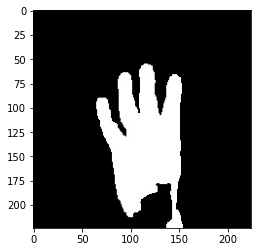

Label: 4


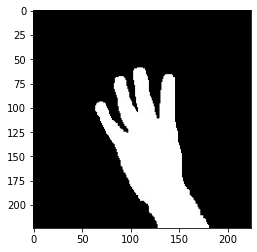

Label: 4


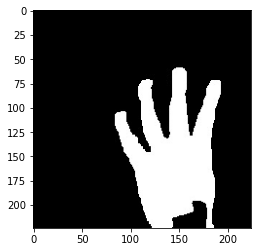

Label: 4


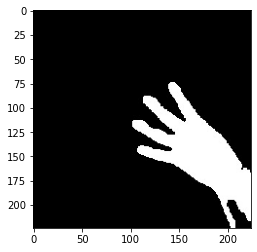

Label: 4


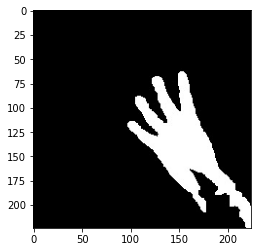

Label: 4


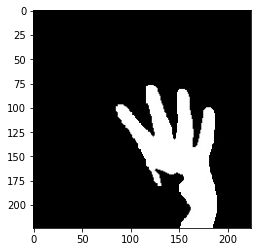

Label: 4


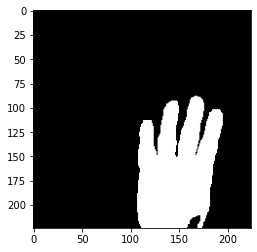

Label: 4


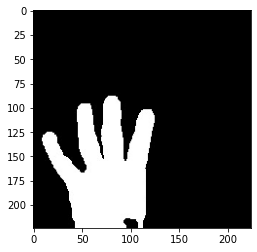

Label: 5


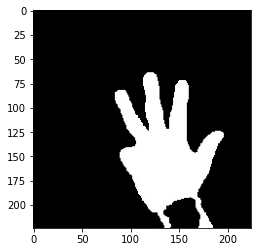

Label: 5


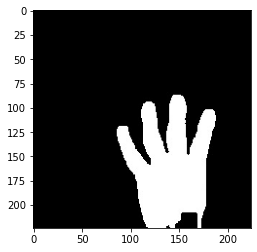

Label: 3


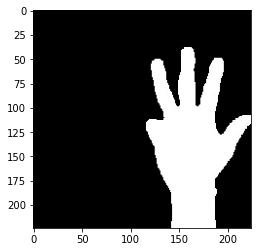

Label: 4


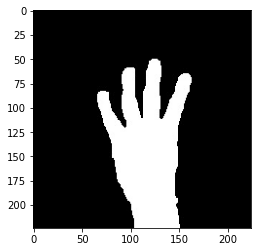

Label: 4


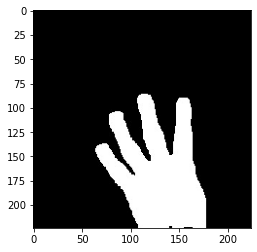

Label: 4


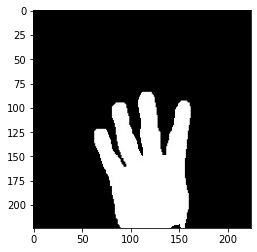

Label: 4


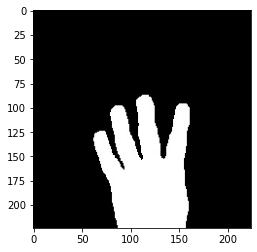

Label: 4


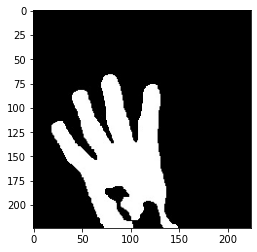

Label: 4


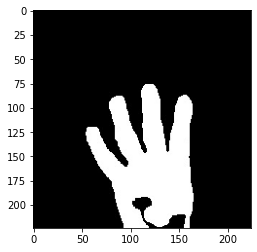

Label: 4


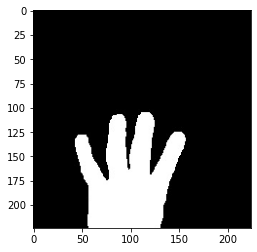

Label: 5


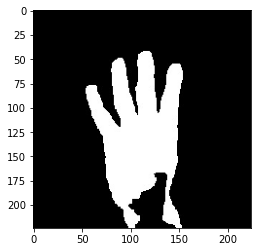

Label: 4


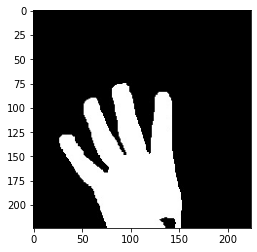

Label: 5


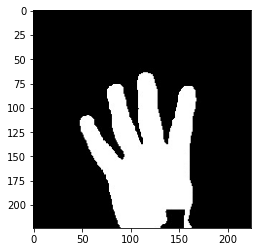

Label: 4


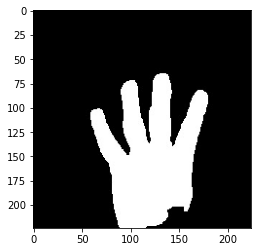

Label: 5


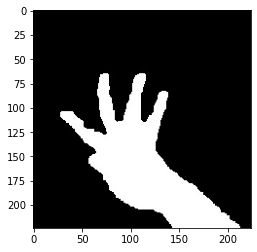

Label: 4


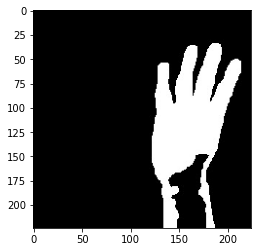

Label: 4


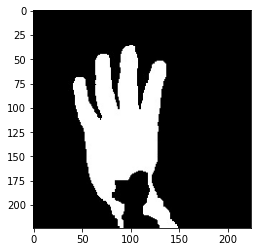

Label: 4


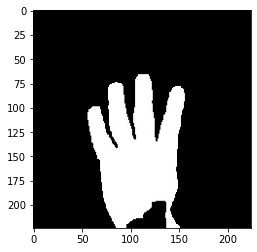

Label: 4


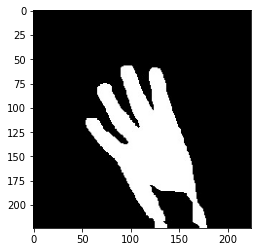

Label: 4


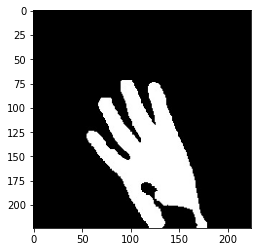

Label: 5


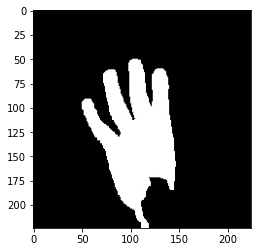

Label: 4


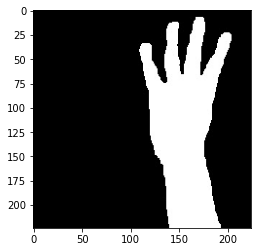

Label: 5


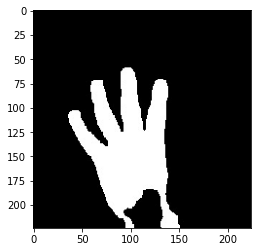

Label: 4


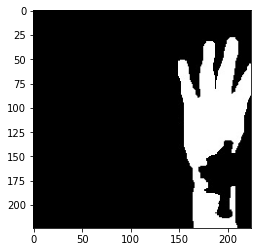

Label: 4


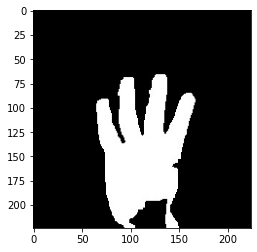

Label: 4


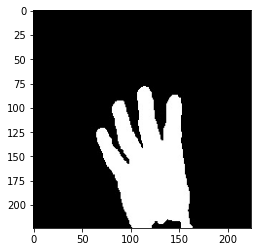

Label: 4


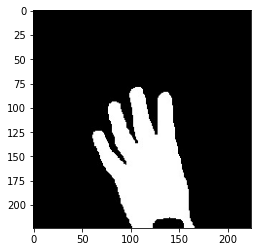

Label: 4


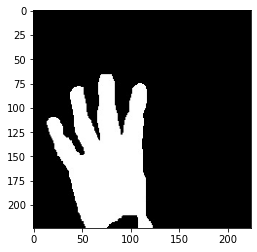

Label: 4


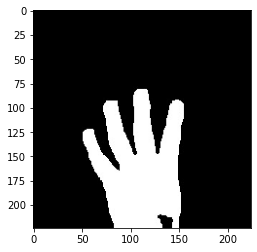

Label: 4


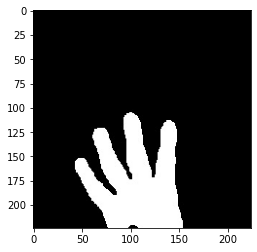

Label: 5


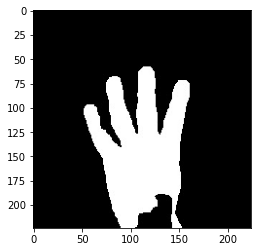

Label: 5


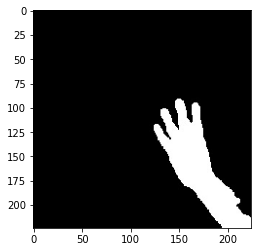

Label: 4


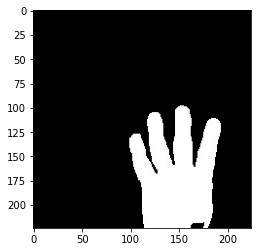

Label: 4


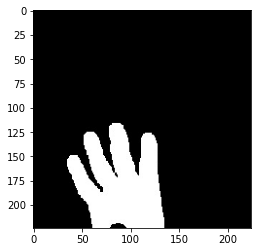

Label: 4


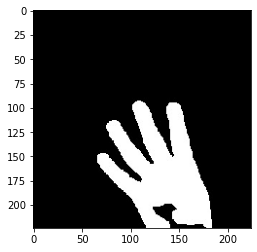

Label: 4


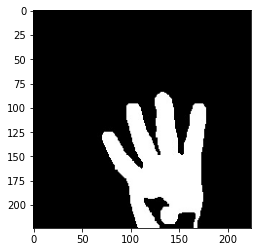

Label: 4


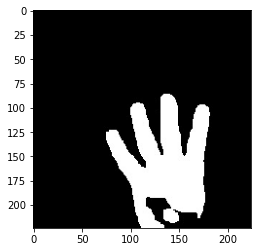

Label: 5


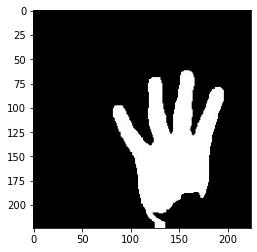

Label: 1


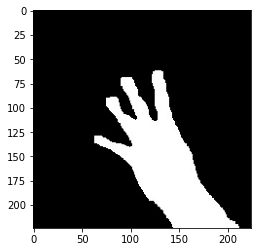

Label: 4


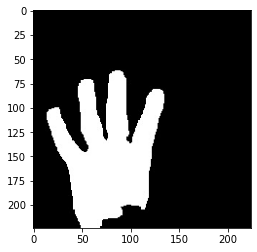

Label: 4


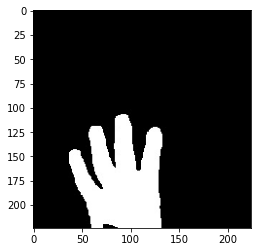

Label: 4


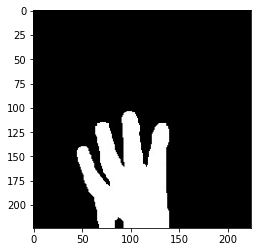

Label: 4


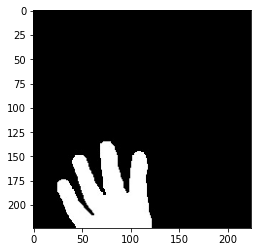

Label: 4


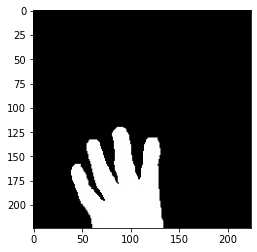

Label: 4


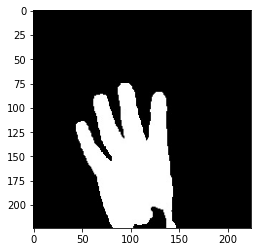

Label: 4


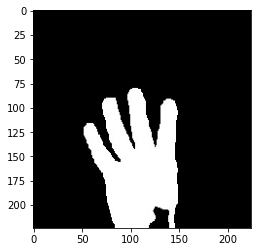

Label: 4


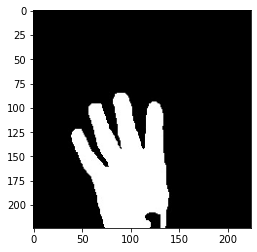

Label: 5


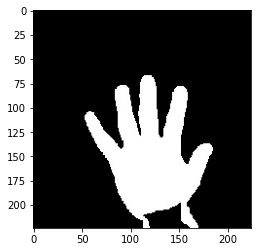

Label: 5


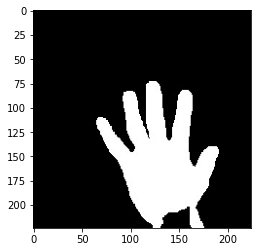

Label: 5


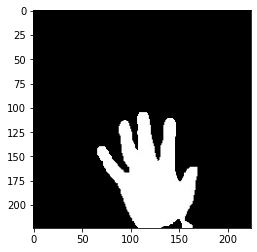

Label: 5


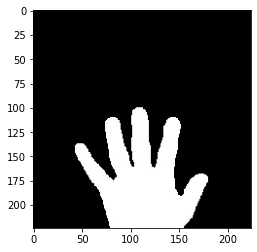

Label: 4


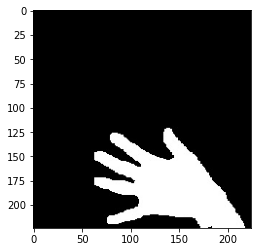

Label: 3


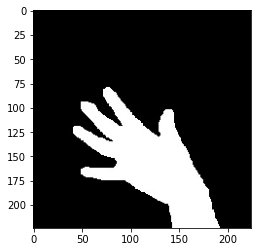

Label: 4


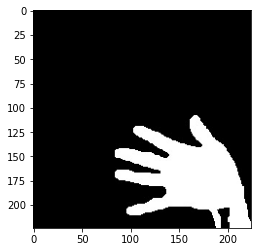

Label: 5


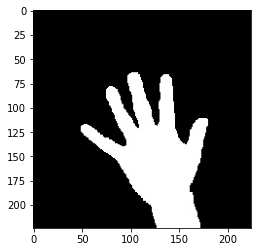

Label: 5


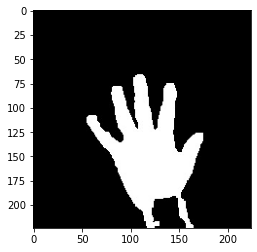

Label: 5


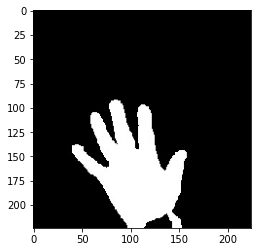

Label: 5


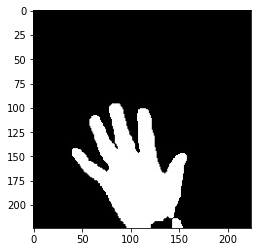

Label: 5


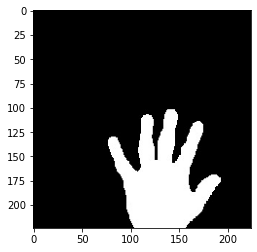

Label: 5


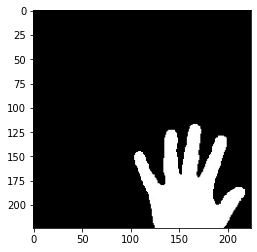

Label: 5


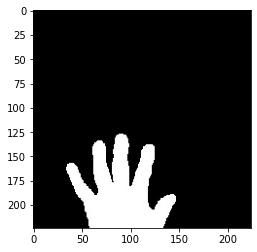

Label: 5


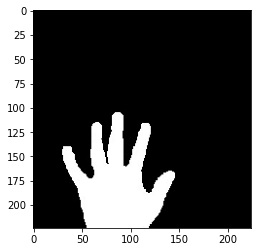

Label: 5


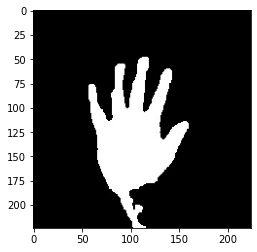

Label: 5


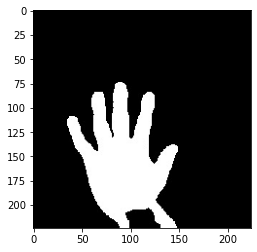

Label: 5


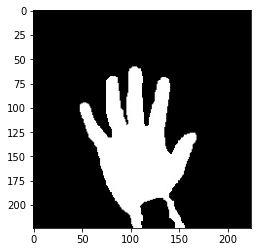

Label: 5


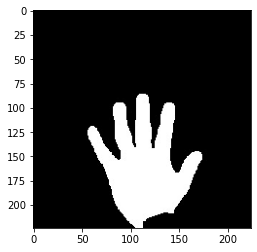

Label: 5


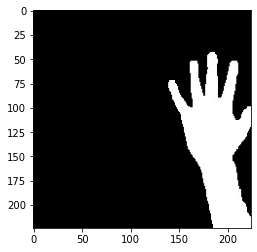

Label: 5


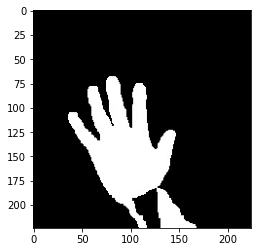

Label: 5


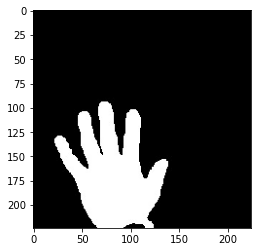

Label: 5


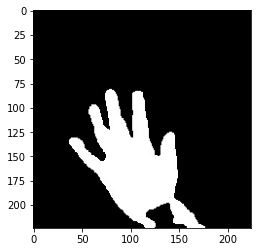

Label: 5


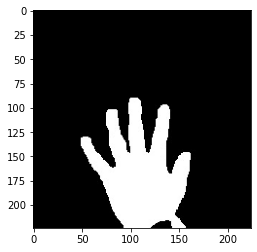

Label: 5


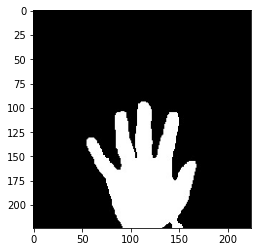

Label: 5


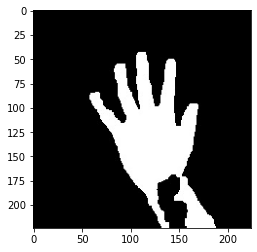

Label: 5


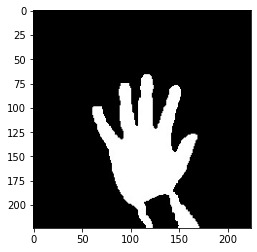

Label: 5


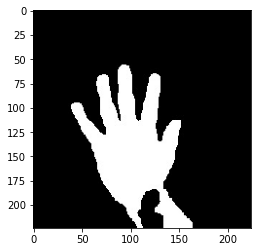

Label: 5


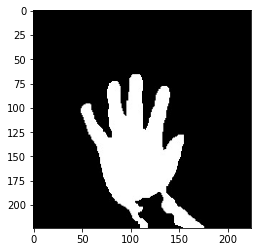

Label: 5


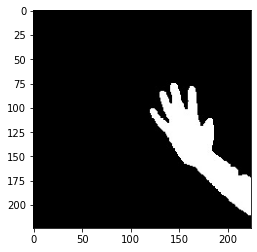

Label: 5


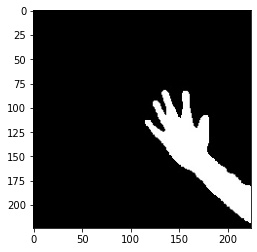

Label: 5


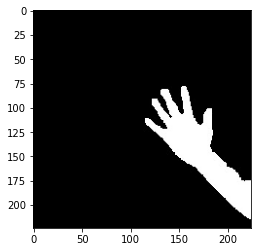

Label: 5


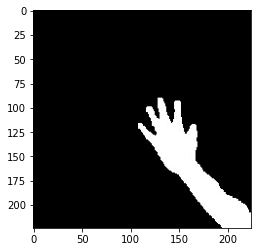

Label: 3


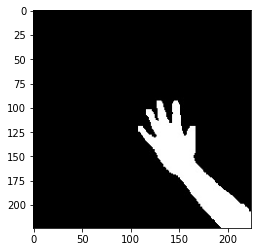

Label: 5


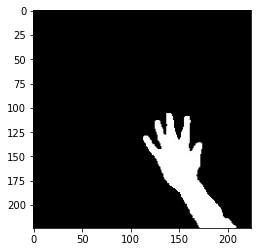

Label: 5


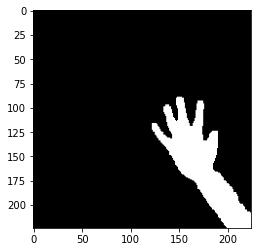

Label: 5


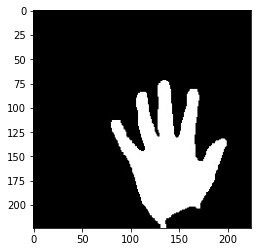

Label: 5


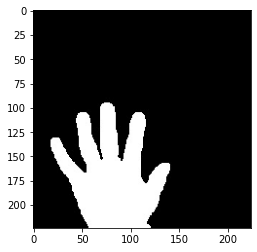

Label: 5


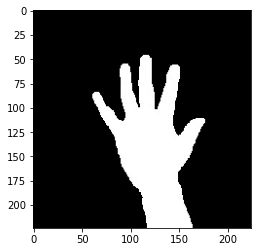

Label: 5


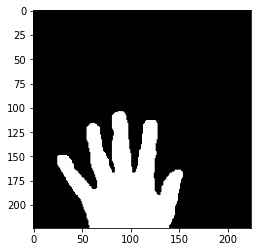

Label: 5


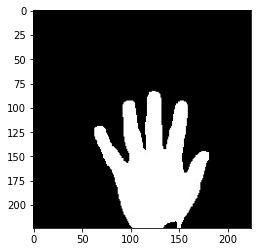

Label: 5


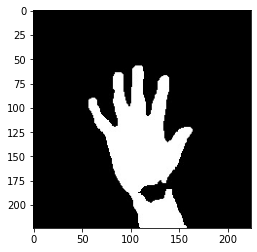

Label: 5


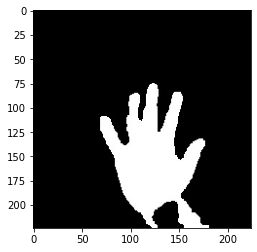

Label: 5


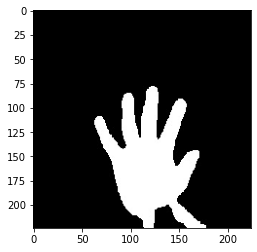

Label: 5


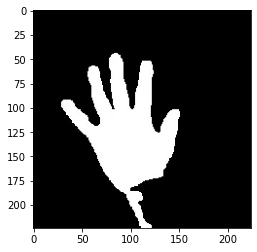

Label: 5


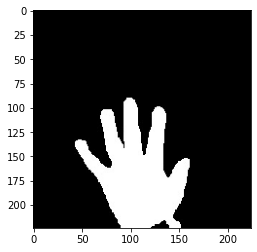

Label: 5


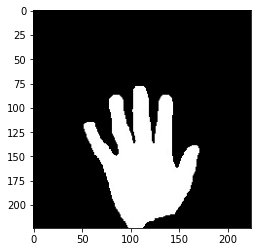

Label: 5


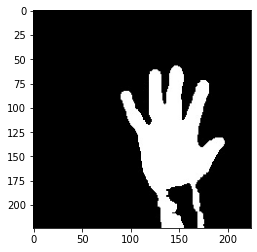

Label: 5


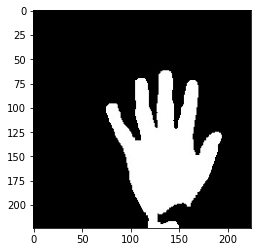

Label: 5


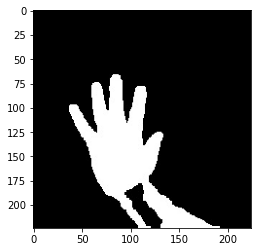

Label: 5


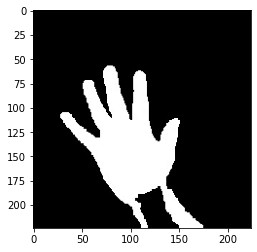

Label: 5


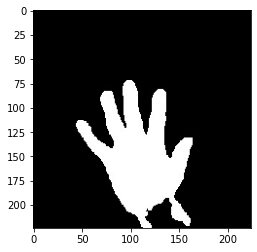

Label: 5


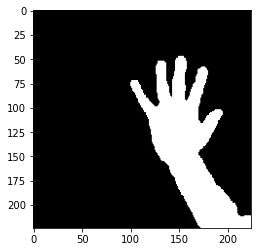

Label: 5


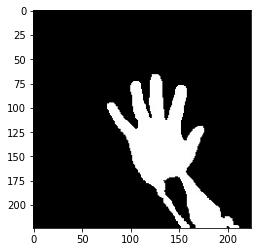

Label: 5


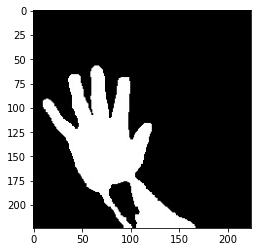

Label: 5


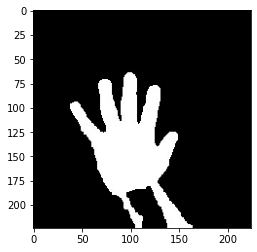

Label: 5


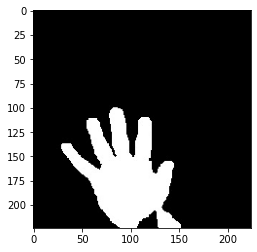

Label: 5


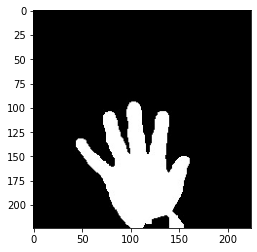

Label: 5


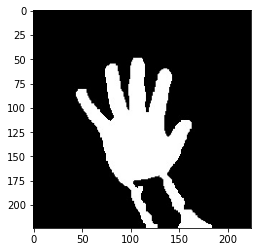

Label: 5


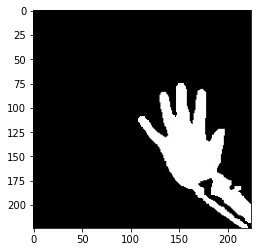

Label: 5


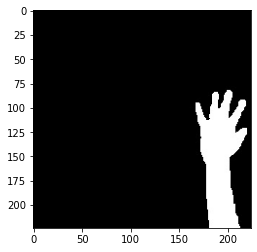

Label: 5


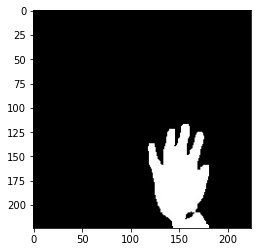

Label: 5


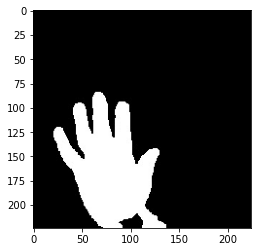

Label: 5


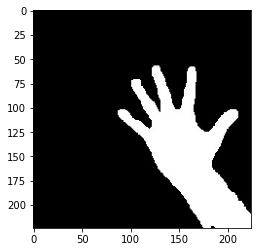

Label: 5


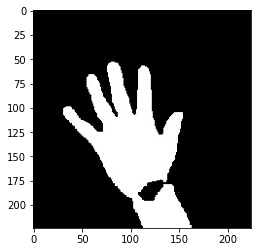

Label: 5


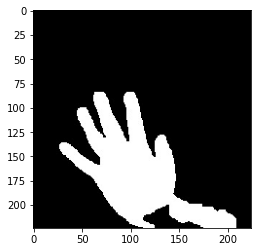

Label: 5


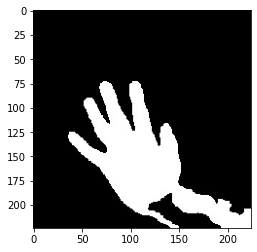

Label: 5


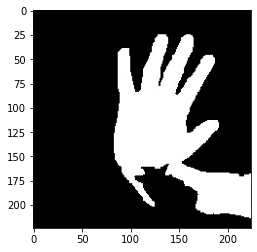

Label: 5


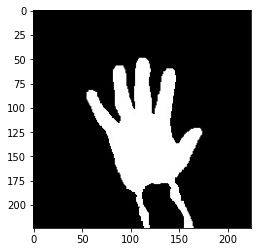

Label: 5


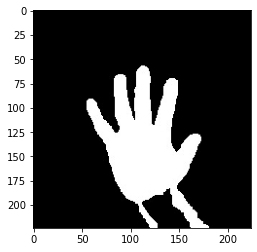

Label: 5


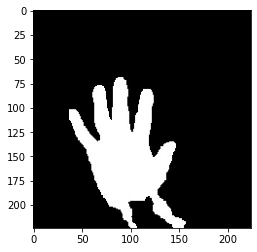

In [128]:
for i in range(len(predictions)):
    plt.imshow(test_imgs[i][0])
    print('Label:',predictions[i]+1)
    plt.show()